In [149]:
import torch
from system import System
from dict import Dict
from functional import Functional

K = System(('i:j:k', 'j:k:l', 'i:k:l'))
K

System (j:k:l) (i:k:l) (j:k) (k) (i:k) (k:l) (i:j:k)

In [150]:
# zeta = sum over subfaces, inverted by mu
zeta, mu = K.Zeta[0], K.Mu[0]

# differential d and codifferential delta = d*
d, delta = K.D[0], K.Delta[1]

# effective energy gradient 
DF = K.Deff[0]

The diffusion associated to generalised belief propagation (GBP) acts by:

$$ \dot u = - \delta \circ \zeta \circ \mathcal{D} (u)$$

In [156]:
def diffusion(D, normalise=False):
    Z = zeta
    if normalise: 
        N = Functional({
            (a|a): lambda Ua: Ua - K.F[a](Ua) for _, a in K.N[0]
        }).curry()
        Z = N @ zeta
    out = Dict()
    out.potential = -1 * delta @ D @ zeta
    out.energy = -1 *  zeta @ delta @ D
    Phi = -1 * D @ zeta
    out.flux = lambda u: lambda phi: Phi(u + delta(phi))
    return out

# GBP diffusion
GBP = diffusion(DF, normalise=True)

# Diffusion with Möbius inversion on messages
mu1 = K.Mu[1]
muGBP = diffusion(mu1 @ DF)

In [157]:
Nit = 10
def integrate(u0, rate=0.5, N=Nit, diffusion=GBP):
    flux = diffusion.flux(u0)
    phi = K.zeros(1)
    out = Dict({
        'phi': [Tensor() for i in range(Nit)],
        'dphi': [Tensor() for i in range(Nit)]
    })
    for t in range(Nit):
        dphi = flux(phi)
        phi = phi + rate * dphi
        out.dphi += [dphi]
        out.phi += [phi]
    return out


In [165]:
import matplotlib.pyplot as plt

[0, 1, 0, 1, 0, 1]

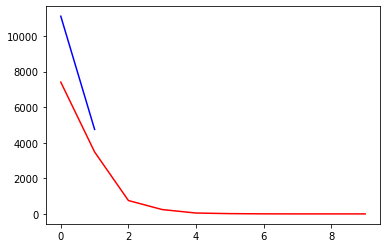

In [162]:
u0 = 10 * K.gaussian(0)

orbit1 = integrate(u0)
orbit2 = integrate(u0, diffusion=muGBP)

x = [i for i in range(Nit)]
y = [psi.norm() for psi in orbit1.dphi]
z = [psi.norm() for psi in orbit2.dphi]
plt.plot(x, y, color="blue")
plt.plot(x, z, color="red")

In [170]:
def convergenceRatio(u0, rate=0.5, N=Nit, diffusion=GBP):
    flux = diffusion.flux(u0)
    phi = K.zeros(1)
    dphi = flux(phi)
    DZ = DF @ zeta
    D0 = DZ(u + delta(phi))
    for t in range(Nit - 1):
        phi += rate * dphi
        dphi = flux(phi)    
    D1 = DZ(u + delta(phi))
    return D1.norm()/D0.norm()

In [181]:
from time import time 
import itertools as it

table = Dict()
rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
beta = [10]
samples = 20

In [182]:
t0 = time()
N = len(beta) * len(rates) * Nit * samples

for r, b in it.product(rates, beta): 
    table[(r, b)] = [[], []]
    for s in range(samples):
        u = b * K.gaussian(0)
        table[(r, b)][0] += [float(convergenceRatio(u, rate=r, N=10, diffusion=GBP))]
        table[(r, b)][1] += [float(convergenceRatio(u, rate=r, N=10, diffusion=muGBP))]
        
t1 = time()
print(f"completed {N} iterations in {t1 - t0} s\n({(t1-t0) * 1000/N} ms/it)")

completed 1600 iterations in 89.29543781280518 ms
(0.055809648633003237 ms/it)


In [183]:
table

Dict {
(0.1, 10) :
 [[inf, nan, 0.04358868673443794, 0.08636733889579773, 0.1094738095998764, 0.1442776620388031, 0.14525574445724487, 0.05032978951931, 0.09571118652820587, 0.13147374987602234, 0.08738991618156433, 0.10699541121721268, 0.11599120497703552, nan, nan, 0.1583564132452011, 0.1502697616815567, 0.10645894706249237, 0.1356547474861145, 0.09901322424411774], [0.07449230551719666, 0.05053725838661194, 0.06494037061929703, 0.11738543212413788, 0.0670117512345314, 0.05429690331220627, 0.054733745753765106, 0.030095215886831284, 0.035359885543584824, 0.04497769474983215, 0.04668306186795235, 0.047695375978946686, 0.10616730898618698, 0.08807498216629028, 0.04468964785337448, 0.08037953823804855, 0.05010607838630676, 0.06315556168556213, 0.03281337395310402, 0.054489556699991226]]

(0.2, 10) :
 [[0.016049614176154137, 0.030698053538799286, nan, nan, 0.024376781657338142, nan, nan, 0.023641932755708694, nan, nan, nan, nan, nan, nan, nan, nan, 0.05798473209142685, 0.0354395247995853

In [184]:
import csv
with open('convergence.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for r in rates: 
        for b in beta: 
            ratio = table[(r, b)]
            writer.writerow(
                [r, b, 1/b] \
                + [float(r) for r in ratio[0]] + [''] + [float(r) for r in ratio[1]] )
        